# Digital Signal Image Processing Assignment - Kalman Filtering

**Riccardo Caprile 4370774**

Implements a Kalman filter for the estimation of a function $f$ and its first derivative $f'$ in the interval [0,10] from 1000 equally spaced noisy samples.

Define f: [0,1] -> R as $$ f(t) = sin(pt)e^{qt}$$

with $p$ and $q$ sampled uniformly in the interval [2,4]. For i = 0,1,...,999 let $t_i$ = i / 1000 and $f_i = f(t_i) + \epsilon_i $ with $ \epsilon_i$ sampled from a Gaussian distribution with $\mu = 0 $ and $\sigma = 0.1$ and $\sigma = 0.5$.

Plot the estimates against the values for $f$ and $f'$ computed analytically in the two cases. 

Study how the filtered estimates change for increasing values of the noise process covariance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

# Uniform Sampling of $p$ and $q$

In [2]:
p = np.random.uniform(2,4)
q = np.random.uniform(2,4)

# Sampling $t_i$

In [3]:
t_i = np.zeros(1000)
i = np.arange(0,1000)
n = len(t_i)
t_i = i/1000

# $f(t)$ and $f'(t)$

In [4]:
f_t = np.sin(p * t_i) * np.exp(q * t_i)

f_dt  = ((p * np.cos(p * t_i)) * (np.exp(q * t_i))) + ((q * np.sin(p * t_i)) * (np.exp(q * t_i)))

# Measurement Models for $f(t)$ and $f'(t)$

In [5]:
mu = 0

        
def measurements_f(t, sigma):
    m_f = np.zeros(len(t))
    epsilon = np.random.normal(mu, sigma, len(t))
    
    for i in range(0, 1000):
        m_f[i] = (np.sin(p * t[i]) * np.exp(q * t[i])) + epsilon[i]
        
    return m_f

# Kalman Filter Description and Implementation

Kalman filter is an algorithm that uses a series of measurements and predictions to obtain the optimal estimate of a system when the k-th measurement is acquired. We need to remember that the future samples are correlated with the current sample.

The algorithm uses a process model that describes how the system changes over time.

The Linear Kalman Filter algorithm can be built as it follows : 

1. Acquire the measurement $m_k$ , computed with the measurement model implemented before
2. Set the Kalman gain : $K_k = P_k^- H^T (H P_k^- H^T + R)^{-1}$
3. State update : $\hat{s}_{k}=\hat{s}_{k}^-+K_{k}\big(m_{k}-H\hat{s}_{k}^-\big)$
4. Covariance update : $P_{k}=(I-K_{k}H)P^-_{k}$
5. State estimate projection : $\hat{s}^{-}_{k+1} = \Phi\hat{s}_k$
6. Covariance estimate projection :  $P^{-}_{k+1} = \Phi P_k\Phi^T + Q$
7. k $\leftarrow$ k + 1

In [6]:
def naive_KF(m, P_pred, s_pred, Phi, H, Q, R):
    """Naive Kalman Filter implementation.
    
    Inputs:
    - m (M-dim float) the new measurement
    - P_pred (NxN-dim float array) error covariance prediction
    - s_pred (N-dim float array) state prediction
    - Phi (float array) state transition matrix
    - H (MxN-dim float array) measurement matrix  
    - Q (NxN-dim float array) process noise covariance
    - R (MxM-dim float) measurement noise variance
    """
    N = len(s_pred);
    
    # Kalman gain

    K = np.dot(P_pred, H.T) * float((np.dot(np.dot(H, P_pred),H.T) + R)) ** -1
    K = K[:,None] ## add newaxis 
         
    # Update
    _reserr  = m - np.dot(H, s_pred)
    s = s_pred + (K * _reserr) 
    IKH = np.eye(N) - np.dot(K,H[:,None].T)
    
    P = np.dot(IKH, P_pred)
    
    # Prediction
    s_pred = np.dot(Phi, s)
    P_pred = np.dot(np.dot(Phi, P), Phi.T) 
   
    P_pred = P_pred + Q
    
    return P_pred, s_pred

# First Case : Estimates with $\sigma$ = 0.1

In [7]:
sigma_1 = 0.1

m_f = measurements_f(t_i,sigma_1)

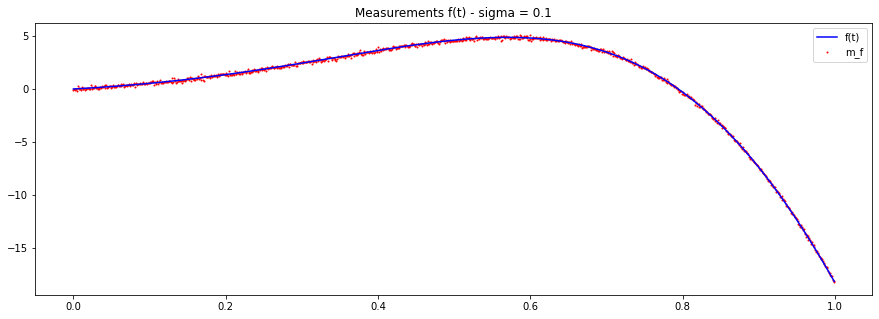

In [8]:
plt.scatter(t_i, m_f, s = 4, color = 'r', marker = '.', label = 'm_f')
plt.plot(t_i, f_t, color = 'b', label = 'f(t)')
plt.title("Measurements f(t) - sigma = 0.1")
plt.legend()
plt.show()

As we can see for this case  $\sigma$ = 0.1 , means that the noise is pretty small and all the measurements are close to $f(t)$ function.

The measurement variance R represents the uncertainty in the measurements , and it is used as a weighting factor in the estimation process.

Small variance brings reliable measurements.

In [9]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

In [10]:
Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1e-6, 0],[0,5]]) # process noise covariance
R = sigma_1 # measurement variance

In [11]:
# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [12]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    
    
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

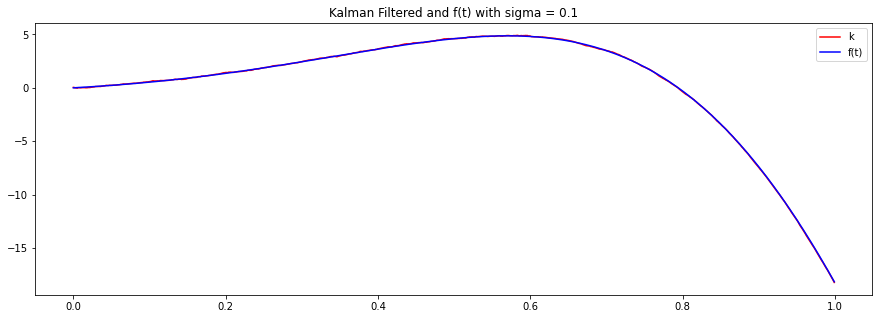

In [13]:
plt.plot(t_i, func, color = 'r', label = 'k')
plt.plot(t_i, f_t, color = 'b', label = 'f(t)')
plt.title("Kalman Filtered and f(t) with sigma = 0.1")
plt.legend()
plt.show()

In [14]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

In [15]:
Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1, 0],[0,5]]) # process noise covariance
R = sigma_1 # measurement variance

In [16]:
# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [17]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    
    
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

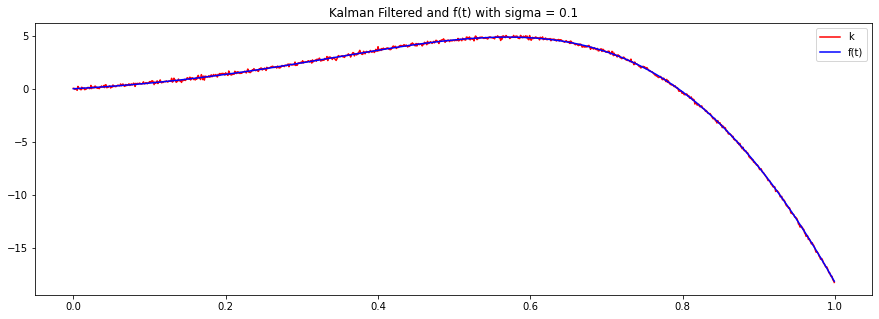

In [18]:
plt.plot(t_i, func, color = 'r', label = 'k')
plt.plot(t_i, f_t, color = 'b', label = 'f(t)')
plt.title("Kalman Filtered and f(t) with sigma = 0.1")
plt.legend()
plt.show()

# $f'(t)$ with $\sigma$ = 0.1

In [19]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

In [20]:
Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1e-6, 0],[0,5]]) # process noise covariance
R = sigma_1 # measurement variance

In [21]:
# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [22]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    
    
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

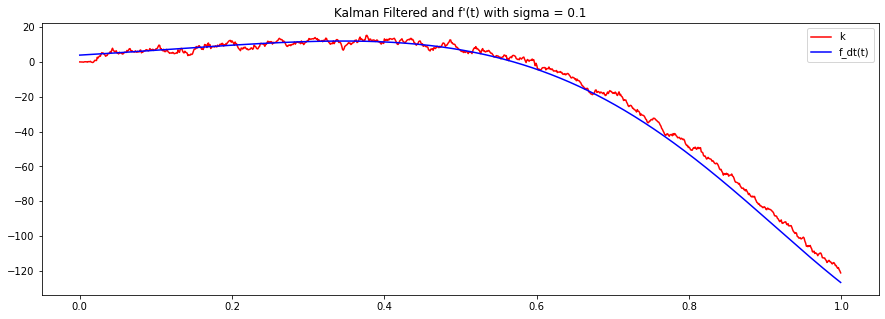

In [23]:
plt.plot(t_i, der, color = 'r', label = 'k')
plt.plot(t_i, f_dt, color = 'b', label = 'f_dt(t)')
plt.title("Kalman Filtered and f'(t) with sigma = 0.1")
plt.legend()
plt.show()

# Second Case : Estimates with $\sigma$ = 0.5

We , now , follow the same steps as before but with a different $\sigma$

In [24]:
sigma_2 = 0.5


m_f = measurements_f(t_i,sigma_2)

It is clear that the noise has been increased.

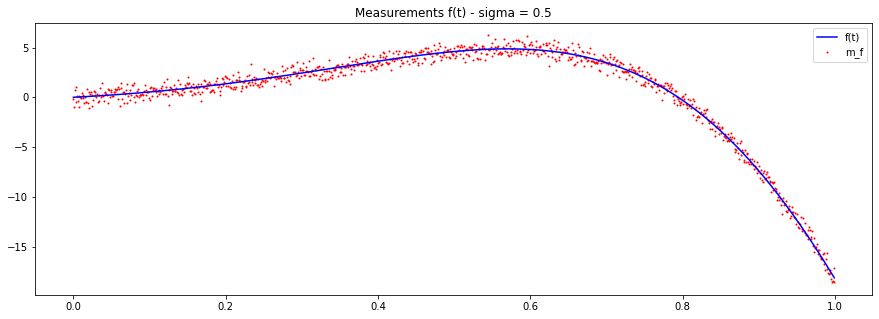

In [25]:
plt.scatter(t_i, m_f, s = 4, color = 'r', marker = '.', label = 'm_f')
plt.plot(t_i, f_t, color = 'b', label = 'f(t)')
plt.title("Measurements f(t) - sigma = 0.5")
plt.legend()
plt.show()

In [26]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

In [27]:
Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1e-6, 0],[0,5]]) # process noise covariance
R = sigma_1 # measurement variance

In [28]:
# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [29]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    
    
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

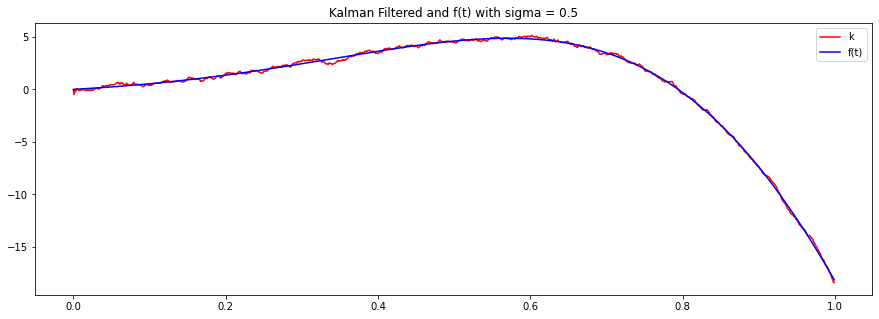

In [30]:
plt.plot(t_i, func, color = 'r', label = 'k')
plt.plot(t_i, f_t, color = 'b', label = 'f(t)')
plt.title("Kalman Filtered and f(t) with sigma = 0.5")
plt.legend()
plt.show()

As expected the results is not precise and smooth as before.

**As before , let's try to increase the process noise covariance Q in order to obtain an even more less precise result**

In [31]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

In [32]:
Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1, 0],[0,5]]) # process noise covariance
R = sigma_1 # measurement variance

In [33]:
# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [34]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    
    
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

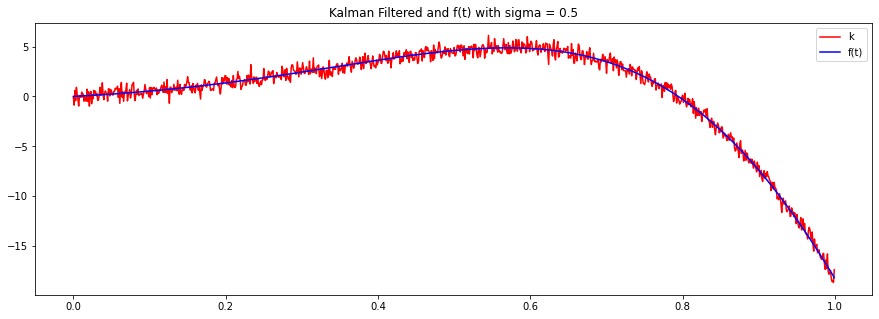

In [35]:
plt.plot(t_i, func, color = 'r', label = 'k')
plt.plot(t_i, f_t, color = 'b', label = 'f(t)')
plt.title("Kalman Filtered and f(t) with sigma = 0.5")
plt.legend()
plt.show()

# $f'(t)$ with $\sigma$ = 0.5

In [36]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

In [37]:
Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1e-6, 0],[0, 5]]) # process noise covariance
R = sigma_2 # measurement variance

In [38]:
# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [39]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    
    
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

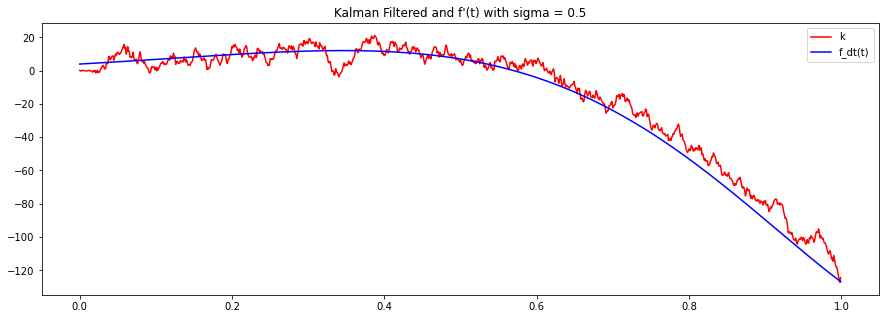

In [40]:
plt.plot(t_i, der, color = 'r', label = 'k')
plt.plot(t_i, f_dt, color = 'b', label = 'f_dt(t)')
plt.title("Kalman Filtered and f'(t) with sigma = 0.5")
plt.legend()
plt.show()